In [1]:
import time
import numpy as np 
import torch
import torch.nn.functional as F 
from torchvision import datasets ,models
from torchvision import transforms 
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt 
import cv2
import os 
import torch.nn as nn
import random 
import glob
from PIL import Image
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage.interpolation import map_coordinates
from torch.utils.data.sampler import SubsetRandomSampler
import torch.utils.data as data
from skimage import io 
from skimage.exposure import histogram




In [74]:
# Wandb init
# import wandb
# os.environ['WANDB_API_KEY'] = "344338e09b93dd41994593b9dd0fbcbe9407580c"

# hyperparameter_defaults = dict(
#     dropout = 0.5,
#     epochs = 15,
# )

# wandb.init(config = hyperparameter_defaults, project = "racial_bias")
# config = wandb.config

In [2]:
train_on_gpu = torch.cuda.is_available()

In [3]:
if not train_on_gpu:
    print("CUDA is not available. Training on CPU")
else:
    print("CUDA is available. Training on GPU")

CUDA is not available. Training on CPU


In [4]:
data_dir = '/Users/swastik/ophthalmology/Racial_Bias/Dataset2'
train_dir = os.path.join(data_dir,'training/')
test_dir = os.path.join(data_dir,'test/')

classes = ['DR','Non_DR']

In [5]:
train_transform = transforms.Compose([transforms.Resize((512,512)),
                                transforms.RandomHorizontalFlip(p=0.5),
                                transforms.RandomVerticalFlip(p=0.5),
                                transforms.RandomRotation(30),
                                transforms.RandomRotation(60),
                                transforms.RandomRotation(90),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.224])
                               ])
test_transform = transforms.Compose([transforms.Resize((512,512)),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.224])
                                    ])

In [6]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [7]:
train_data = datasets.ImageFolder(train_dir,transform = train_transform)
test_data = datasets.ImageFolder(test_dir,transform = test_transform)

In [18]:
batch_size = 5

In [19]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                          shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


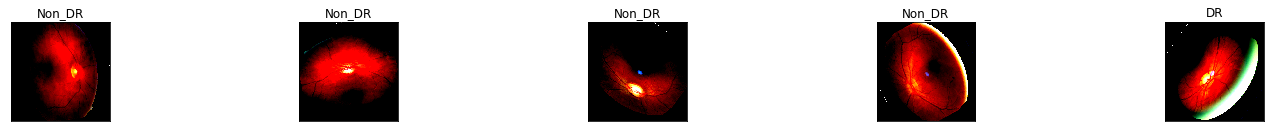

In [20]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()


fig = plt.figure(figsize=(25,4))
for idx in np.arange(5):
    ax = fig.add_subplot(2, 5, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

In [9]:
vgg16 = models.vgg16(pretrained=True)
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [11]:
print(vgg16.classifier[6].in_features) 
print(vgg16.classifier[6].out_features) 

4096
1000


In [12]:
for param in vgg16.features.parameters():
    param.requires_grad = False

In [13]:
n_inputs = vgg16.classifier[6].in_features
last_layer = nn.Linear(n_inputs, len(classes))
vgg16.classifier[6] = last_layer
if train_on_gpu:
    vgg16.cuda()

print(vgg16.classifier[6].out_features)

2


In [14]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.classifier.parameters(), lr=0.001)

In [15]:
print("Num of training images:",len(train_data))
print("Num of testing images:",len(test_data))

Num of training images: 101
Num of testing images: 26


In [71]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.classifier.parameters(), lr=0.001)

In [16]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def train(n_epochs, train_loader,test_loader, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output,target)
            loss.backward()
            optimizer.step()
            
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(test_loader):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            loss = criterion(output,target)
            valid_loss +=  valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,valid_loss))
            torch.save(model.state_dict(), 'model_racial.pt')
            torch.save(model,'com_racial.pt')
            torch.save
            valid_loss_min = valid_loss
    # return trained model
    return model


# train the model
model_scratch = train(20, train_loader, test_loader, vgg16, optimizer, 
                      criterion, use_cuda)

NameError: name 'train_loader' is not defined